In [1]:
import pandas as pd
import numpy as np
import time
import plotly.express as px
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import acovf,acf,pacf
from sklearn.metrics import mean_squared_error

In [2]:
store_df = pd.read_csv('data/store.csv')
test_df = pd.read_csv('data/test.csv')
train_df = pd.read_csv('data/train.csv')
sample_submission_df = pd.read_csv('data/sample_submission.csv')

/tmp/ipykernel_8881/3598239639.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('data/train.csv')


In [3]:
train_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


## Data preprocessing

#### Checking any problems with the data

In [4]:
train_df.StateHoliday.unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

The value 0 occurs in two data types

In [5]:
train_df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [6]:
def one_hot_encode(df, column_name):
    one_hot_df = pd.get_dummies(df[column_name], prefix=column_name+"_", drop_first=False, dtype=int)
    new_cols = df.columns.drop(column_name)
    new_df = pd.concat([df[new_cols], one_hot_df], axis=1)
    return new_df

def preprocess_data(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df.loc[df['StateHoliday'] == 0, 'StateHoliday'] = '0'
    df = one_hot_encode(df, 'StateHoliday')
    df = df.sort_values(by=['Store', 'Date']).reset_index(drop=True)
    # df = df.iloc[::-1].reset_index(drop=True)
    
    return df
    

In [7]:
train_df = preprocess_data(train_df)
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday__0,StateHoliday__a,StateHoliday__b,StateHoliday__c
0,1,2,2013-01-01,0,0,0,0,1,0,1,0,0
1,1,3,2013-01-02,5530,668,1,0,1,1,0,0,0
2,1,4,2013-01-03,4327,578,1,0,1,1,0,0,0
3,1,5,2013-01-04,4486,619,1,0,1,1,0,0,0
4,1,6,2013-01-05,4997,635,1,0,1,1,0,0,0


In [8]:
test_df.shape

(41088, 8)

In [9]:
test_df = preprocess_data(test_df)
test_df["StateHoliday__b"] = len(test_df) * [0]
test_df["StateHoliday__c"] = len(test_df) * [0]
test_df.head()

,Id,Store,DayOfWeek,Date,Open,Promo,SchoolHoliday,StateHoliday__0,StateHoliday__a,StateHoliday__b,StateHoliday__c
0,40233,1,6,2015-08-01,1.0,0,1,1,0,0,0
1,39377,1,7,2015-08-02,0.0,0,1,1,0,0,0
2,38521,1,1,2015-08-03,1.0,1,1,1,0,0,0
3,37665,1,2,2015-08-04,1.0,1,1,1,0,0,0
4,36809,1,3,2015-08-05,1.0,1,1,1,0,0,0


In [10]:
# train_df["Store"].unique()
for store_id in train_df["Store"].unique():
   print("Training store: ", store_id)
   start_time = time.time()

   store_train_df = train_df[train_df["Store"] == store_id]
   store_test_df = test_df[test_df["Store"] == store_id]

   exog_cols = ['DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'StateHoliday__0', 'StateHoliday__a',
      'StateHoliday__b', 'StateHoliday__c']
   # exog = store_train_df[exog_cols].to_numpy()

   model = SARIMAX(store_train_df['Sales'], exog=store_train_df[exog_cols], order=(1, 1, 2), seasonal_order=(2, 0, 0, 7))
   model_fit = model.fit(disp=False)

   start = len(store_train_df)
   end = start + len(store_test_df) - 1

   print("From: ", start, " To: ", end)

   forecast = model_fit.predict(start=start, end=end, exog=store_test_df[exog_cols])
   store_test_df.loc[store_test_df["Store"] == store_id, "Sales"] = forecast

   print("Time taken: ", time.time() - start_time)

Training store:  1


/home/harsh242/mambaforge/envs/rossmann2/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


From:  942  To:  989
Time taken:  3.5628583431243896
Training store:  2


/tmp/ipykernel_8881/259127630.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store_test_df.loc[store_test_df["Store"] == store_id, "Sales"] = forecast
/home/harsh242/mambaforge/envs/rossmann2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/harsh242/mambaforge/envs/rossmann2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/harsh242/mambaforge/envs/rossmann2/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likeli

From:  942  To:  941


ValueError: Prediction must have `end` after `start`.

## Exploring the data

In [12]:
corr_df = train_df[list(train_df.columns[1:])].corr()
corr_df

,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday__0,StateHoliday__a,StateHoliday__b,StateHoliday__c
DayOfWeek,1.000000,0.000183,-0.462125,-0.386445,-0.528963,-0.392925,-0.205388,0.052889,-0.040981,-0.040668,-0.001345
Date,0.000183,1.000000,0.041904,0.012679,-0.000157,0.017249,0.001068,-0.003736,-0.001144,-0.000957,0.013887
Sales,-0.462125,0.041904,1.000000,0.894711,0.678472,0.452345,0.085124,0.254216,-0.203028,-0.117497,-0.092618
Customers,-0.386445,0.012679,0.894711,1.000000,0.616768,0.316169,0.071568,0.226608,-0.180900,-0.104522,-0.083007
Open,-0.528963,-0.000157,0.678472,0.616768,1.000000,0.295042,0.086171,0.378378,-0.302107,-0.175158,-0.137685
Promo,-0.392925,0.017249,0.452345,0.316169,0.295042,1.000000,0.067483,0.012353,-0.004034,0.019847,-0.049964
SchoolHoliday,-0.205388,0.001068,0.085124,0.071568,0.086171,0.067483,1.000000,-0.148651,0.029126,0.159098,0.136405
StateHoliday__0,0.052889,-0.003736,0.254216,0.226608,0.378378,0.012353,-0.148651,1.000000,-0.803389,-0.458547,-0.358514
StateHoliday__a,-0.040981,-0.001144,-0.203028,-0.180900,-0.302107,-0.004034,0.029126,-0.803389,1.000000,-0.011599,-0.009069
StateHoliday__b,-0.040668,-0.000957,-0.117497,-0.104522,-0.175158,0.019847,0.159098,-0.458547,-0.011599,1.000000,-0.005176


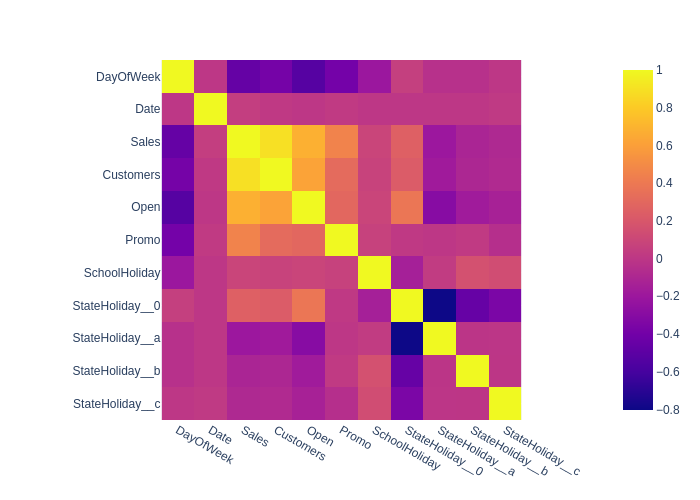

In [13]:
fig = px.imshow(corr_df)
fig.show("png")

Customers and Open columns are strongly correlated with Sales

## SARIMAX model (with exogenous)

In [10]:
train_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'SchoolHoliday', 'StateHoliday__0', 'StateHoliday__a',
       'StateHoliday__b', 'StateHoliday__c'],
      dtype='object')

In [11]:
exog_cols = ['DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'StateHoliday__0', 'StateHoliday__a',
       'StateHoliday__b', 'StateHoliday__c']
exog = train_df[exog_cols].to_numpy()
print(exog.shape)
exog


(1017209, 8)


array([[2, 0, 0, ..., 1, 0, 0],
       [3, 1, 0, ..., 0, 0, 0],
       [4, 1, 0, ..., 0, 0, 0],
       ...,
       [3, 1, 1, ..., 0, 0, 0],
       [4, 1, 1, ..., 0, 0, 0],
       [5, 1, 1, ..., 0, 0, 0]])

In [12]:
search_res = auto_arima(df_store_x['Sales'], exog, start_p=0, start_q=0, max_p=3, max_q=8, seasonal=True, 
                        m=7, max_P=8, max_D=4, max_Q=8, trace=True)

NameError: name 'df_store_x' is not defined

In [32]:
search_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  942
Model:             SARIMAX(1, 1, 2)x(2, 0, [], 7)   Log Likelihood               -8053.525
Date:                            Tue, 04 Jun 2024   AIC                          16137.051
Time:                                    10:58:40   BIC                          16209.755
Sample:                                         0   HQIC                         16164.765
                                            - 942                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0637      0.484      0.131      0.895      -0.885       1.012
x1           -48.5681     56.209     -0.864      0.388    -158.737      61.600
x2          7556.5469    467.988     16.147      0.000    6639.306    8473.787
x3          1957.5149    144.167     13.578      0.000    1674.953    2240.076
x4          -188.4885    143.191     -1.316      0.188    -469.138      92.161
x5           228.8744   2330.257      0.098      0.922   -4338.346    4796.094
x6         -1101.2499   2248.951     -0.490      0.624   -5509.112    3306.612
x7         -1413.7737   2274.083     -0.622      0.534   -5870.895    3043.348
x8          2285.7320   2359.872      0.969      0.333   -2339.532    6910.996
ar.L1          0.5813      0.070      8.353      0.000       0.445       0.718
ma.L1         -1.1929      0.074    -16.030      0.000      -1.339      -1.047
ma.L2          0.2015      0.072      2.792      0.005       0.060       0.343
ar.S.L7        0.0776      0.028      2.785      0.005       0.023       0.132
ar.S.L14       0.3527      0.024     14.646      0.000       0.306       0.400
sigma2      1.569e+06   4.79e+04     32.745      0.000    1.48e+06    1.66e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               439.81
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                             0.41
Prob(H) (two-sided):                  0.19   Kurtosis:                         6.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
sarimax = SARIMAX(store_train_df['Sales'], exog=store_train_df[exog_cols], order=(1, 1, 2), seasonal_order=(2, 0, 0, 7))
sarimax_model = sarimax.fit()
sarimax_model.summary()

/projectnb/ivc-ml/harshk/miniconda3/envs/notebook/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/projectnb/ivc-ml/harshk/miniconda3/envs/notebook/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.60400D+00    |proj g|=  5.44728D-02

At iterate    5    f=  8.59481D+00    |proj g|=  1.92348D-02

At iterate   10    f=  8.57624D+00    |proj g|=  5.59253D-03

At iterate   15    f=  8.57477D+00    |proj g|=  4.94966D-04

At iterate   20    f=  8.57476D+00    |proj g|=  2.31032D-04

At iterate   25    f=  8.57473D+00    |proj g|=  2.60238D-03

At iterate   30    f=  8.57180D+00    |proj g|=  1.10457D-02

At iterate   35    f=  8.55874D+00    |proj g|=  2.19648D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                  892
Model:             SARIMAX(1, 1, 2)x(2, 0, [], 7)   Log Likelihood               -7634.391
Date:                            Mon, 03 Jun 2024   AIC                          15296.781
Time:                                    09:23:17   BIC                          15363.874
Sample:                                         0   HQIC                         15322.423
                                            - 892                                         
Covariance Type:                              opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
DayOfWeek         -33.6513     60.465     -0.557      0.578    -152.160      84.858
Open             7652.6695    493.855     15.496      0.000    6684.731    8620.608
Promo            1959.4282    151.417     12.941      0.000    1662.657    2256.200
SchoolHoliday    -158.7711    149.782     -1.060      0.289    -452.339     134.797
StateHoliday__0   162.3193   2346.144      0.069      0.945   -4436.038    4760.676
StateHoliday__a -1072.2034   2248.063     -0.477      0.633   -5478.325    3333.918
StateHoliday__b -1398.1948   2276.622     -0.614      0.539   -5860.292    3063.902
StateHoliday__c  2307.6273   2383.474      0.968      0.333   -2363.896    6979.151
ar.L1               0.6257      0.060     10.409      0.000       0.508       0.743
ma.L1              -1.2362      0.069    -17.788      0.000      -1.372      -1.100
ma.L2               0.2365      0.066      3.570      0.000       0.107       0.366
ar.S.L7             0.0815      0.028      2.890      0.004       0.026       0.137
ar.S.L14            0.3656      0.023     16.030      0.000       0.321       0.410
sigma2           1.594e+06   5.29e+04     30.151      0.000    1.49e+06     1.7e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               440.11
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                             0.42
Prob(H) (two-sided):                  0.21   Kurtosis:                         6.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
start = len(store_train_df)
end = start + len(store_test_df) - 1
sarimax_forecast = sarimax_model.predict(start=start, end=end, exog=store_test_df[exog_cols])

/projectnb/ivc-ml/harshk/miniconda3/envs/notebook/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/projectnb/ivc-ml/harshk/miniconda3/envs/notebook/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



In [45]:
store_test_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday__0,StateHoliday__a,StateHoliday__b,StateHoliday__c
922135,1011,5,2015-06-12,6048,708,1,0,0,1,0,0,0
922136,1011,6,2015-06-13,6531,853,1,0,0,1,0,0,0
922137,1011,7,2015-06-14,0,0,0,0,0,1,0,0,0
922138,1011,1,2015-06-15,10660,1016,1,1,0,1,0,0,0
922139,1011,2,2015-06-16,7895,854,1,1,0,1,0,0,0


In [46]:
# forecast_df = store_test_df[['Store', 'Date', 'Sales']].copy()
forecast_df['SarimaxForecast'] = np.array(sarimax_forecast)
forecast_df.head()

,Store,Date,Sales,SarimaForecast,SarimaxForecast
922135,1011,2015-06-12,6048,7826.453616,6868.667424
922136,1011,2015-06-13,6531,6451.905214,6985.494969
922137,1011,2015-06-14,0,929.493840,-489.510929
922138,1011,2015-06-15,10660,6861.623832,9865.396821
922139,1011,2015-06-16,7895,5719.771558,8699.963379


In [47]:
forecast_df.tail()

,Store,Date,Sales,SarimaForecast,SarimaxForecast
922180,1011,2015-07-27,10066,2013.426036,9110.056190
922181,1011,2015-07-28,8673,1104.313806,9005.857587
922182,1011,2015-07-29,7755,1122.678231,8968.908454
922183,1011,2015-07-30,9227,891.132225,8956.657735
922184,1011,2015-07-31,10134,451.565945,8927.047608


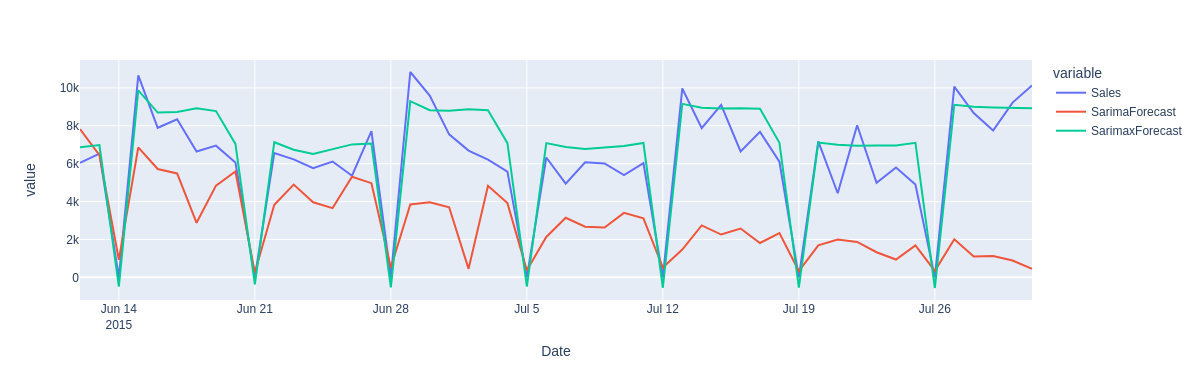

In [48]:
fig = px.line(forecast_df, x="Date", y=["Sales", "SarimaForecast", "SarimaxForecast"], width=1200, height=380)
fig.show("png")

In [49]:
sarima_rmse = np.sqrt(mean_squared_error(forecast_df['Sales'], forecast_df['SarimaForecast']))
sarimax_rmse = np.sqrt(mean_squared_error(forecast_df['Sales'], forecast_df['SarimaxForecast']))
print("sarima_rmse: ", sarima_rmse)
print("sarimax_rmse: ", sarimax_rmse)

sarima_rmse:  4321.817841389038
sarimax_rmse:  1241.4548739223058


## Conclusion

The SARIMAX model with exogenous variables is performing significantly better. The correlation plots show that sales data is related to the Customer, Close, and Open columns, so it makes sense that the model's performance has improved after including this data.
